<a href="https://colab.research.google.com/github/seoharu/DATA-AI/blob/main/face_mask_detection_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2
from scipy.spatial import distance


import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive'):
  for filename in filenames:
    print(os.path.join(dirname, filename))


/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_russian_plate_number.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_eye.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_profileface.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_frontalcatface.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_fullbody.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_lowerbody.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_righteye_2splits.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_licence_plate_rus_16stages.xml
/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_frontal

In [ ]:
face_model = cv2.CascadeClassifier('/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/haarcascades_archive/haarcascade_frontalface_default.xml')


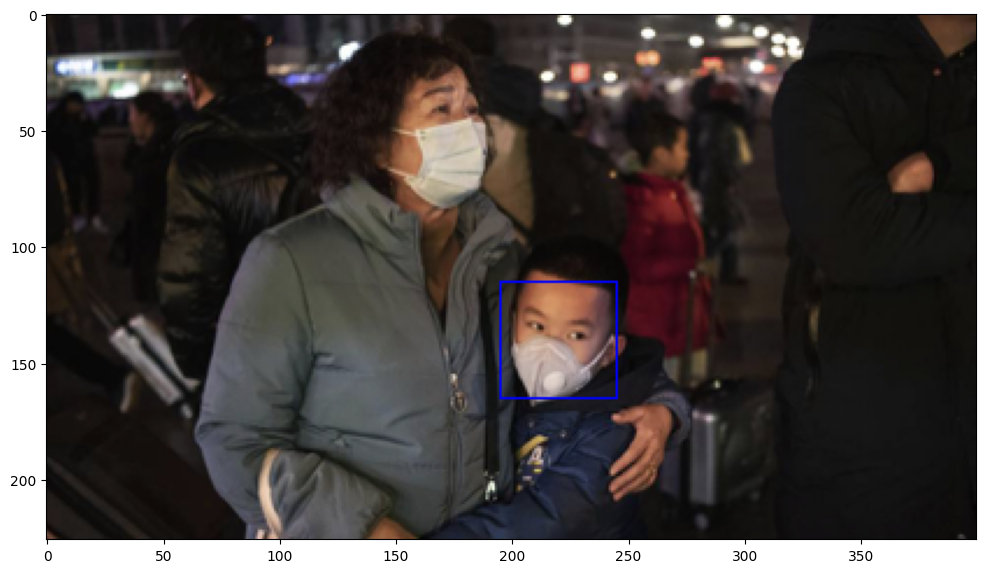

In [ ]:
import matplotlib.pyplot as plt
img = cv2.imread('/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/images/maksssksksss302.png')        # trying it out on a sample image
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)      # ????

faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)   # returns a list of (x, y, w, h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#plotting
for (x, y, w, h) in faces:
  cv2.rectangle(out_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
plt.figure(figsize=(12, 12))
plt.imshow(out_img)


In [ ]:
MIN_DISTANCE = 130

In [ ]:
if len(faces) >= 2:
  label = [0 for i in range(len(faces))]
  for i in range(len(faces)-1):
    for j in range(i+1, len(faces)):
      dist = distance.euclidean(faces[i][:2], faces[j][:2])
      if dist < MIN_DISTANCE:
        label[i] = 1
        label[j] = 1
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)    # colored output image
  for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    if label[i] == 1:
      cv2.rectangle(new_img, (x, y), (x+w, y+h), (255, 0, 0), 1)
    else:
      cv2.rectangle(new_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
  plt.figure(figsize=(10, 10))
  plt.imshow(new_img)

else:
  print("No. of faces detected is less than 2")

No. of faces detected is less than 2


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Load train & test set
train_dir = '/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/vgg19_archive/Face Mask Dataset/Train'
test_dir = 'content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/vgg19_archive/Face Mask Dataset/Test'
val_dir = '/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/vgg19_archive/Face Mask Dataset/Validation'


In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(128, 128), class_mode='categorical', batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir, target_size=(128, 128), class_mode = 'categorical', batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir, target_size=(128, 128), class_mode = 'categorical', batch_size = 32)


Found 757 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg19.layers:
  layer.trainable = False

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20040770 (76.45 MB)
Trainable params: 16386 (64.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = "accuracy")


In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

<ipython-input-18-71cc3d49c955>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


ValueError: ignored

In [ ]:
model.evaluate_generator(test_generator)


<ipython-input-20-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


ValueError: ignored

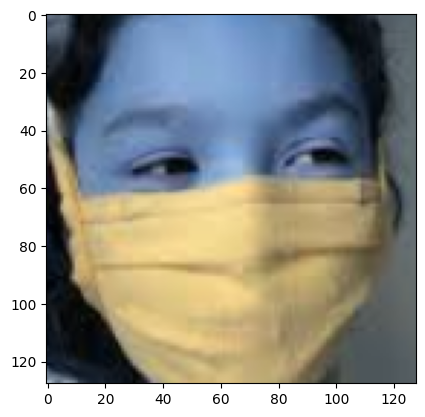

In [ ]:
# Testing the model on the test data

sample_mask_img = cv2.imread('/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/vgg19_archive/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img, (128, 128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img, [1, 128, 128, 3])
sample_mask_img = sample_mask_img / 255.0


In [ ]:
model.predict(sample_mask_img)

1/1 [==============================] - 1s 841ms/step


array([[0.59289956, 0.4600771 ]], dtype=float32)

In [ ]:
# save the model

model.save('masknet.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
mask_label = {0: 'MASK', 1:'NO MASK'}
dist_label = {0:(0, 255, 0), 1:(255, 0, 0)}


In [ ]:
if len(faces) >= 2:
  label = [0 for i in range(len(faces))]
  for i in range(len(faces)-1):
    for j in range(i+1, len(faces)):
      dist = distance.euclidean(faces[i][:2], faces[j][:2])
      if dist < MIN_DISTANCE:
        label[i] = 1
        label[j] = 1
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)          # colored output image
  for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = new_img[y:y+h, x:x+w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshzpe(crop, [1, 128, 128, 3])/255.0
    mask_result = model.predict(crop)
    cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, dist_label[label[i]], 2)
    cv2.rectangle(new_img, (x, y), (x+w, y+h), dist_label[label[i]], 1)
  plt.figure(figsize=(10, 10))
  plt.imshow(new_img)

else:
  print("No. of faces detected is less than 2")

No. of faces detected is less than 2
